# Setting up environment and importing modules

In [1]:

%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
#os.environ["BART_TOOLBOX_PATH"] = "/home/usr/razzaquer/Desktop/ese5934_project/ese5934_project/bart"
#"/Users/chunxuguo/bart"
import torch
import torchopt
from einops import rearrange, reduce# Array manipulation
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct
from ese5934_project.tasks.Recon_Method_Final_Attempt import conjugate_gradient_reconstruct
from ese5934_project.tasks.Recon_Method_Final_Attempt import reconstruct_cg


# Create a mask function

In [2]:

mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[1])




# The `data_transform` function takes raw MRI data (`kspace`, `mask`) as input, applies normalization and undersampling, 
# estimates coil sensitivity maps, and returns the processed data in a format suitable for use in MRI reconstruction tasks.

In [3]:


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm




# Extracting the Data

In [4]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path("/home/usr/razzaquer/Desktop/ese5934_project/Main Data"),
    transform=data_transform,
    challenge="multicoil",
)

In [8]:
# Check the data type of the dataset object

dataset_type = type(dataset)
print("Dataset Type:", dataset_type)
len(dataset)

Dataset Type: <class 'fastmri.data.mri_data.SliceDataset'>


33

In [54]:
# Access contents in the dataset

#for data in dataset:
    #print(data)  # Assuming each element of the dataset is printed


In [8]:
#Accessing all elements

first_element = dataset[0]  
print("First Element:", first_element)

tensor([[[5.0087e-05, 1.3522e-04]]]) tensor([[[0.2028, 0.2027]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.
First Element: (tensor([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         ...,

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
         

In [10]:
#Accessing any one element 

TUP1=dataset[2]
len(TUP1) #Any one element is a tuple, with 5 elements, among them 1 is a tuple, and rest 4 are tensors, among them 3 have the dimension torch.Size([15, 640, 368, 2]), and 1 has dimension ([1,1,368,1]) 

tensor([[[0.0008, 0.0007]]]) tensor([[[0.6448, 0.6412]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


5

In [11]:
# Access the tuple


# Extract each element of the tuple
element1 = TUP1[0]
element2 = TUP1[1]
element3 =TUP1[2]
element4 =TUP1[3]
element5 = TUP1[4]

# Print or use each extracted element as needed
print("Element 1:", element5)


Element 1: tensor([[[[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., 0.]],

         [[0., -0.],
          [0., -0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., -0.]],

         ...,

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., -0.],
          [0., -0.],
          [0., -0.]],

         [[0., -0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., -0.],
          [0., -0.]]],


        [[[0., -0.],
          [0., -0.],
          [0., -0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0

In [12]:
element4.shape
#len(element2)
"In MRI, k-space data with multiple coils often arises from parallel imaging techniques, where multiple receiver coils are used to acquire data simultaneously. Each coil captures a portion of the k-space data independently, allowing for faster acquisition and improved signal-to-noise ratio."

"Given that your k-space data has 15 coils, the first dimension of the tensor with size 15 likely represents each coil. Therefore, the shape `[15, 640, 368, 2]` can be interpreted as follows:"

"- 15: Number of coils."
"- 640: Number of samples along the frequency encoding direction."
"- 368: Number of samples along the phase encoding direction."
"- 2: Complex values (real and imaginary parts) for each data point."

"This shape suggests that you have k-space data acquired from 15 coils, where each coil's data is represented as a 2D array with dimensions `640 x 368` and each data point contains complex values."

"If you have any further questions or need additional clarification, please feel free to ask!"



'If you have any further questions or need additional clarification, please feel free to ask!'

In [5]:
# Reading hdF5 file in general
import h5py

# Open the HDF5 file
with h5py.File('/home/usr/razzaquer/Desktop/ese5934_project/Main Data/file1002570.h5', 'r') as f:
    # List all datasets in the file
    print("Datasets in the HDF5 file:", list(f.keys()))
    # Access a specific dataset (replace 'dataset_name' with the actual dataset name)
    dataset_name = 'kspace'
    dataset = f[dataset_name]

    # Read data from the dataset
    data = dataset[()]  # This reads the entire dataset into a NumPy array

    # Access attributes of the dataset
    attributes = dataset.attrs  # This gets all the attributes associated with the dataset

    # Print dataset shape and attributes
    print("Dataset shape:", data.shape)
    print("Dataset attributes:", attributes)



    

Datasets in the HDF5 file: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Dataset shape: (33, 15, 640, 368)
Dataset attributes: <Attributes of HDF5 object at 140552116874432>


# Grid Field (Voxel Representation)

In [28]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path("/home/usr/razzaquer/Desktop/ese5934_project/Main Data"),
    transform=data_transform,
    challenge="multicoil",
)



#This code is setting up the optimization process for MRI reconstruction, initializing an optimizer, 
#retrieving relevant data from the dataset, and preparing a Grid object for further processing.


#The Grid module represents a trainable grid parameter that can be used as part of a neural network model in PyTorch. 

from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.001)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [12]:
print(kspace.shape,masked_kspace.shape, mask.shape, csm.shape)

#mask.shape: This tensor has a shape of (1, 1, 368, 1).

#The first dimension (1) suggests that there is only one mask in the dataset.
#The second dimension (1) indicates that there is only one channel in the mask.
#The third dimension (368) represents the number of columns in the mask.
#The fourth dimension (1) suggests that there is only one value associated with each column in the mask

torch.Size([15, 640, 368, 2]) torch.Size([15, 640, 368, 2]) torch.Size([1, 1, 368, 1]) torch.Size([15, 640, 368, 2])


# Reconstruction: ADAM Optimizer

In [6]:
params, image_list = reconstruct(
    field,
    torch.rand(1, 2), #tensor([[0.9300, 0.4349]])                
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=8000,
    device=torch.device("cpu"),
)#device=torch.device("cuda")--Try to use it for my server--x should be the inverse fourier transform of y for the initialization

NameError: name 'field' is not defined

In [17]:
type(image_list)
len(image_list)

160

In [14]:
# Applicable for 20 images from 200 iterations 
#import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 1x4
#fig, axs = plt.subplots(1, 4, figsize=(20, 10))
#for i, image in enumerate(image_list):
    #axs[i % 5].imshow(complex_abs(image), cmap="gray")

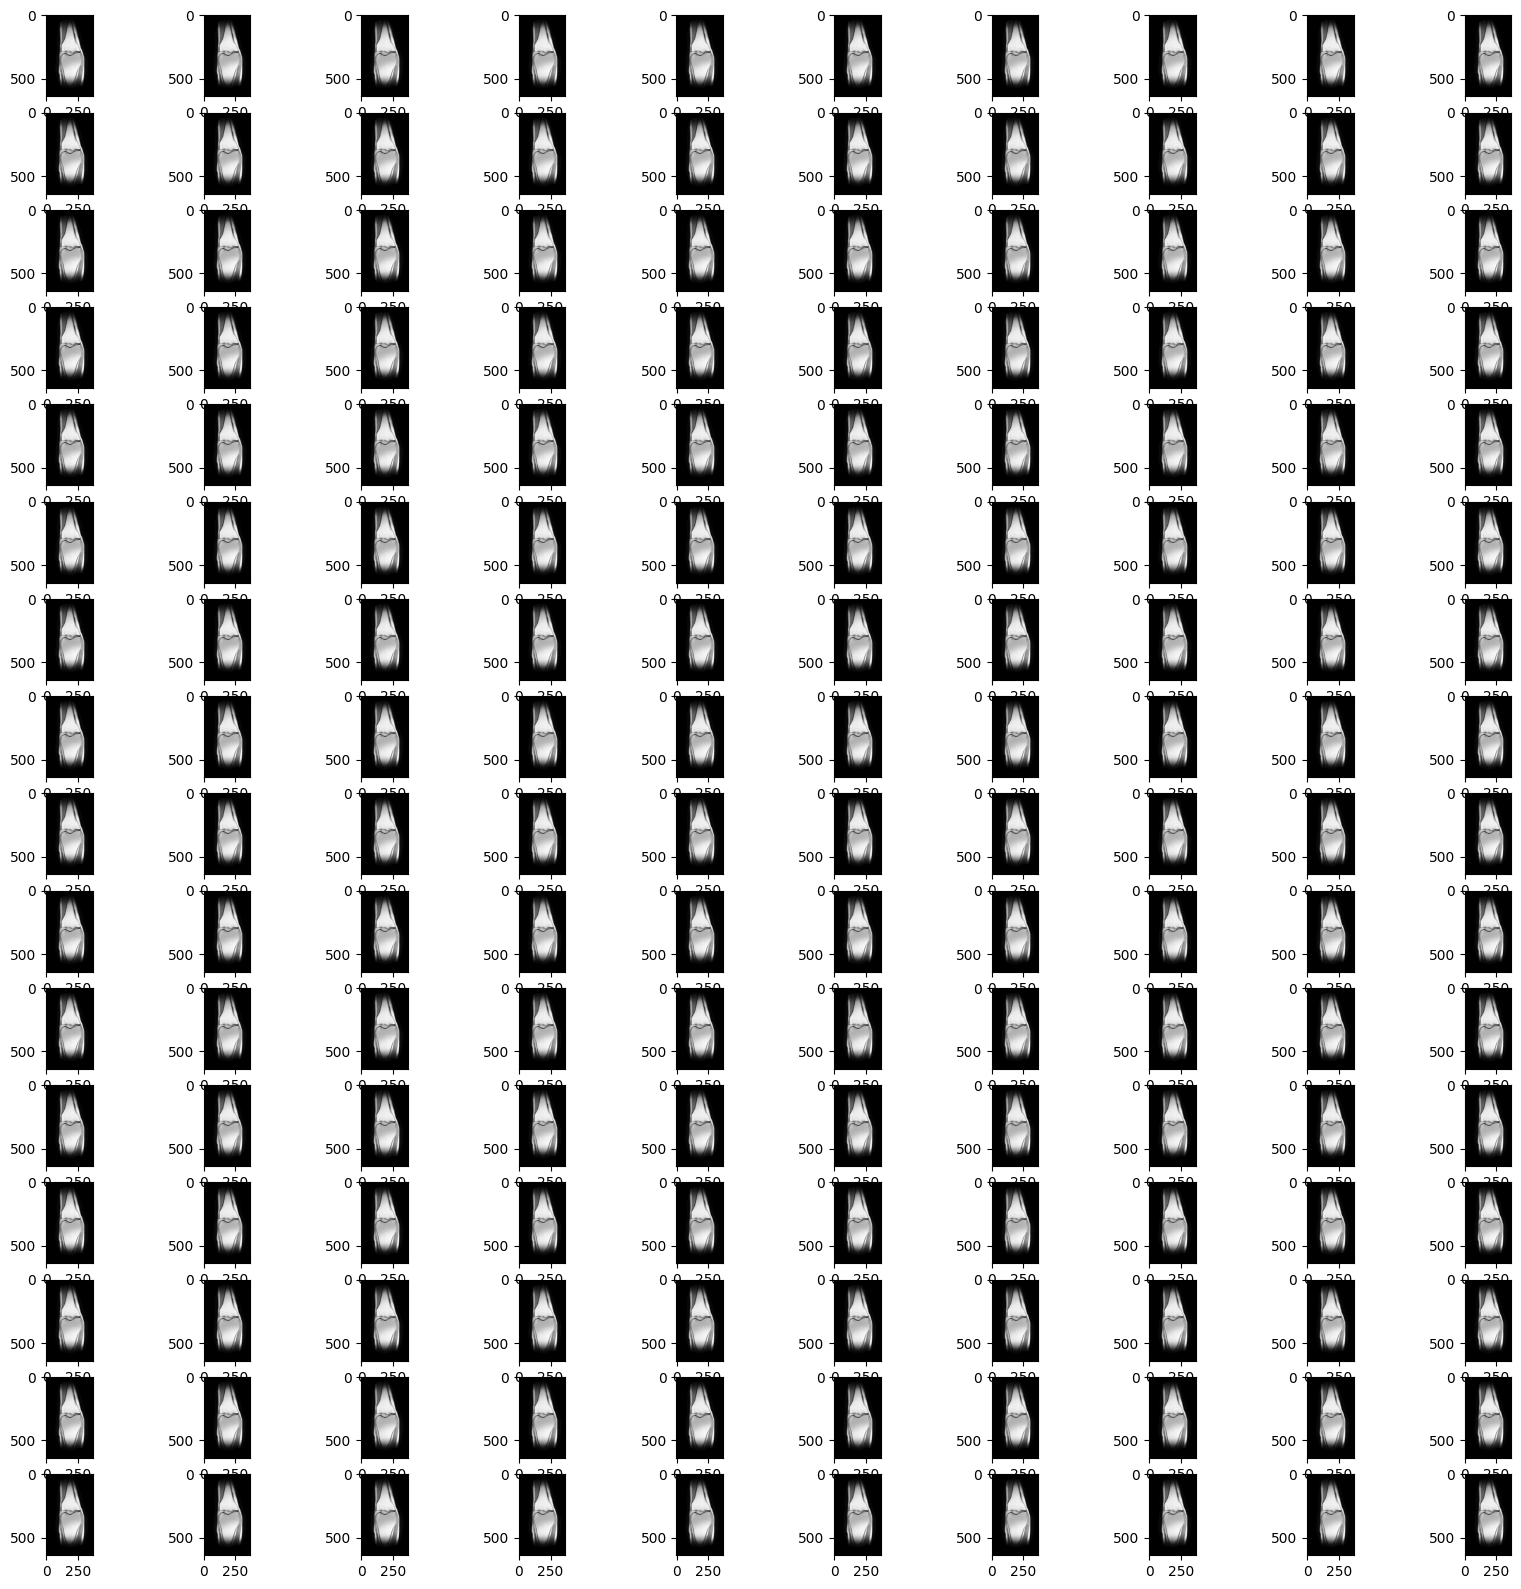

In [19]:
import matplotlib.pyplot as plt

# there are 160 images in the list,
# we want to plot them in a grid of 16x10 (20x8,replace 10 by 8, make figsize= (16,20))
fig, axs = plt.subplots(16, 10, figsize=(20, 20))
for i, image in enumerate(image_list):
    row_idx = i // 10
    col_idx = i % 10
    axs[row_idx, col_idx].imshow(complex_abs(image), cmap="gray")
#plt.show()

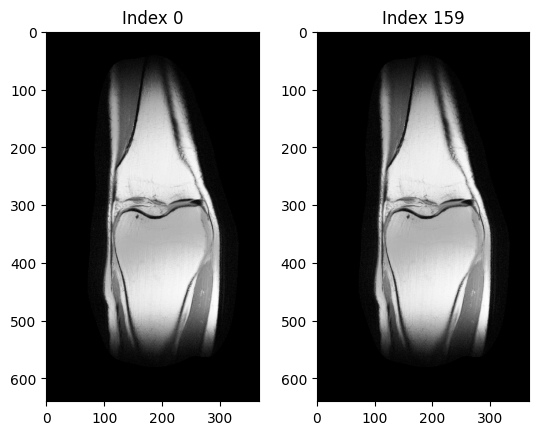

In [20]:
import matplotlib.pyplot as plt

# Plot the first figure of index 0
plt.subplot(1, 2, 1)
plt.imshow(complex_abs(image_list[0]), cmap="gray")
plt.title("Index 0")

# Plot the last figure of index 159
plt.subplot(1, 2, 2)
plt.imshow(complex_abs(image_list[-1]), cmap="gray")
plt.title("Index 159")

plt.show()


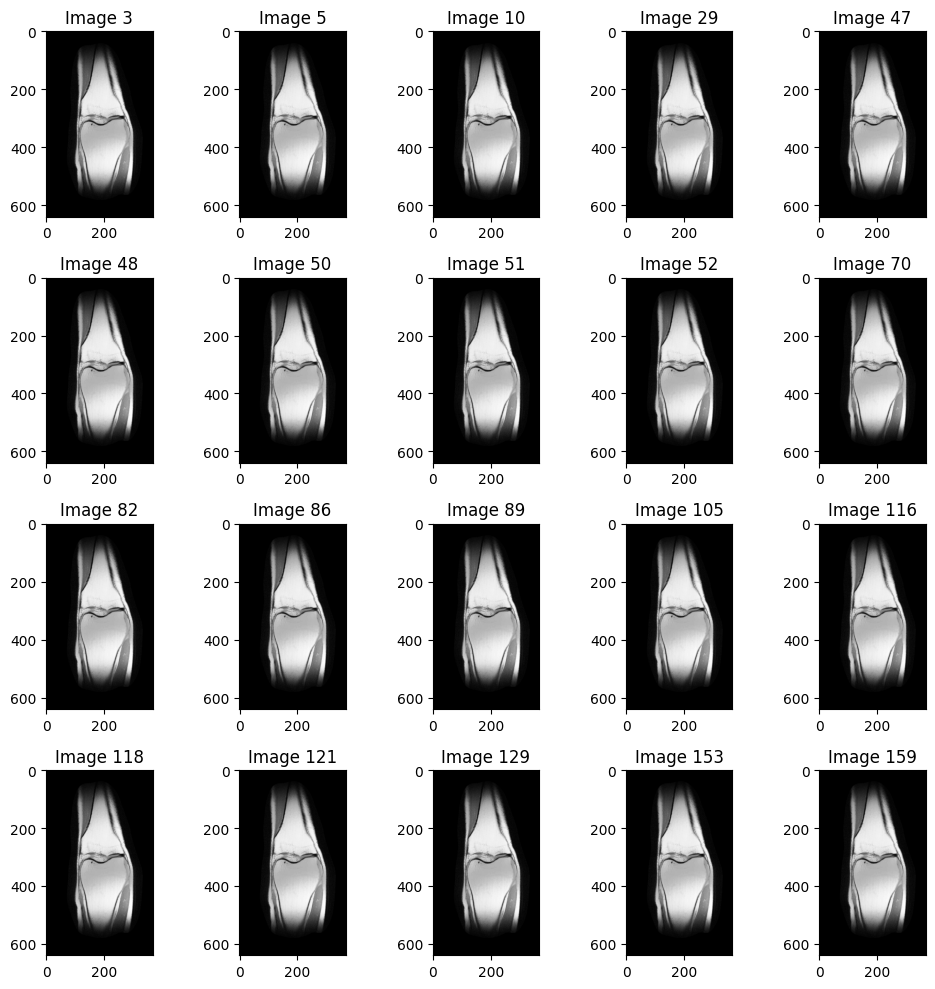

In [21]:
import random
import matplotlib.pyplot as plt

# Randomly select 20 indices from 0 to 159
random_indices =sorted(random.sample(range(160), 20))

# Plot the randomly selected images
fig, axs = plt.subplots(4, 5, figsize=(10, 10))

# Flatten the axs array to easily access each subplot
axs = axs.flatten()

# Plot each randomly selected image
for i, index in enumerate(random_indices):
    image = image_list[index]
    axs[i].imshow(complex_abs(image), cmap="gray")
    axs[i].set_title(f"Image {index+1}")  # Set title for each subplot

# Hide any remaining empty subplots
#for j in range(20, 4 * 5):
    #axs[j].axis("off")

plt.tight_layout()
plt.show()


# Reconstruction: CGM Optimizer

In [7]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path("/home/usr/razzaquer/Desktop/ese5934_project/Main Data"),
    transform=data_transform,
    challenge="multicoil",
)



In [22]:
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [23]:
# Perform reconstruction using the Conjugate Gradient method
reconstructed_image, image_show_list = reconstruct_cg(
    kspace_masked=masked_kspace,
    csm=csm,
    mask=mask,
    masked_forward_model=MaskedForwardModel(),  # Ensure this model is properly defined
    iterations=100,
    device=torch.device("cpu"),
    checkpoint_interval=50  # Adjust as needed
)

# 'reconstructed_image' is the final reconstruction, and 'image_show_list' contains intermediate reconstructions


Iteration 1, Residual norm: 1541066.25
Iteration 2, Residual norm: 7628484.0
Iteration 3, Residual norm: 11851578.0
Iteration 4, Residual norm: 31349148.0
Iteration 5, Residual norm: 54705284.0
Iteration 6, Residual norm: 55945816.0
Iteration 7, Residual norm: 384529760.0
Iteration 8, Residual norm: 384664704.0
Iteration 9, Residual norm: 430505568.0
Iteration 10, Residual norm: 432397184.0
Iteration 11, Residual norm: 432870688.0
Iteration 12, Residual norm: 433050528.0
Iteration 13, Residual norm: 433309344.0
Iteration 14, Residual norm: 433414848.0
Iteration 15, Residual norm: 625381440.0
Iteration 16, Residual norm: 742184576.0
Iteration 17, Residual norm: 742963648.0
Iteration 18, Residual norm: 1029410944.0
Iteration 19, Residual norm: 1031226432.0
Iteration 20, Residual norm: 1031140992.0
Iteration 21, Residual norm: 1031384000.0
Iteration 22, Residual norm: 1033073344.0
Iteration 23, Residual norm: 1033519872.0
Iteration 24, Residual norm: 1033551808.0
Iteration 25, Residual no

In [25]:
reconstructed_image.shape

torch.Size([15, 640, 368, 2])

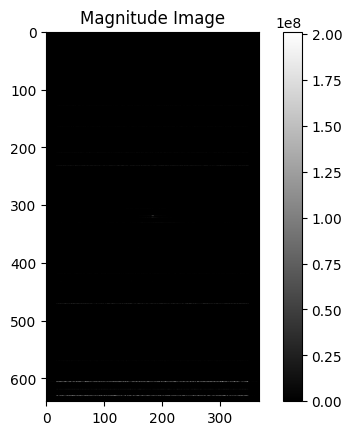

In [26]:
import matplotlib.pyplot as plt

# Assuming reconstructed_image is your tensor
magnitude_image = torch.sqrt(torch.sum(reconstructed_image**2, dim=-1))  # Magnitude calculation

# Plotting the magnitude image
plt.imshow(magnitude_image[0], cmap='gray')  # Plotting the first image in the batch
plt.colorbar()  # Add colorbar to show magnitude scale
plt.title('Magnitude Image')
plt.show()
